In [1]:
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import pandas as pd
import numpy as np

In [2]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)
from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import data_files
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


/home/yoyoteng/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
kwargs = cfg['api']

In [4]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)

from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv
import imp
from models import opt

model_list = [
    ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
    ('xg',models.xg.XgModel,dict(istrain=False)),
    ('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
    ('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)),
    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
    ('simplekfold',models.simplekfold.SimpleKfold,dict(istrain=False)),
    ('disentangle_kfold',models.disentangle_kfold.DisentangleKfoldModel,dict(istrain=False)),
]

In [5]:
X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(314837, 50) (314837,) (78776, 50) (78776,)


In [13]:
import imp
imp.reload(models)
model_list = [
    ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
     #('xg',models.xg.XgModel,dict(istrain=False)),
     #('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
     #('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)), # depends on model from AecAdvModel
#    ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
#     ('disentangle',models.disentangle.DisentangleModel,dict(istrain=False)),
#     ('disentangle_kfold',models.disentangle_kfold.DisentangleKfoldModel,dict(istrain=False)),
#     ('disentanglegan',models.disentanglegan.DisentangleGanModel,dict(istrain=False)),
     #('idg',models.icadisengan.IcaDisentangleGanModel,dict(istrain=False)),
     #('mdg',models.moddisengan.DisentangleModel,dict(istrain=True)),
#    ('tsnesimple',models.tsne_simple.TsneSimple,dict(istrain=False)),
#    ('tsnesimplekfold',models.tsne_simplekfold.TsneSimpleKfold,dict(istrain=False)),
#    ('simple',models.simple.Simple,dict(istrain=False)),
    ('simplekfold',models.simplekfold.SimpleKfold,dict(istrain=False)),
    #('res',models.res.Res,dict(istrain=False)),
    #('highway',models.highway.HighwayModel,dict(istrain=False)),
    #('highway2',models.highway2.HighwayModel,dict(istrain=False)),
    ('highwaykfold',models.highway_kfold.HighwayModel,dict(istrain=False)),
    ('highway2kfold',models.highway2_kfold.HighwayModel,dict(istrain=False)),
]

In [14]:
val_inds = np.array(np.where(_datatypes=='validation')).squeeze()

In [15]:
val_inds.shape

(46362,)

In [16]:

def to_int(e):
    try:
        return int(e.strip('era'))
    except:
        return float('nan')
ll_list = [{},{}]
raw = {}


for n,p in enumerate(['trainpath','testpath']):
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    index_dict={}
    X_train_tr,y_train_tr,X_val_tr,y_val_tr = get_data_era_balanced(
        data_files[-1][p],index_dict=index_dict)
    X__ = X_val_tr
    y__ = y_val_tr
    
    eras__ = eras__[index_dict['validation']]
    
    val_eras = sorted([x for x in np.unique(eras__) if x not in ['eraX']])
    raw[p]={'y_true':y__,'m':{},'eras':eras__,'val_eras':val_eras}
    ll={}
    for name,clsf,params in model_list:
        inst = clsf()
        inst.load()
        y_pred,_ = inst.predict(X__)
        raw[p]['m'][name]={'y_pred':y_pred}
        ll[name]=[]
        for era in val_eras:
            inds = np.array(np.where(eras__==era)).squeeze()            
            l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
            ll[name].append({'eras':to_int(era),'log_loss':l,'stds':np.nanstd(y_pred[inds].squeeze()-y__[inds])})
        ll[name] = pd.DataFrame(ll[name])
    ll_list[n].update(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))
# https://github.com/numerai/submission-criteria/blob/daac1970a984cd4392c720771d3c5c4bcb9de1d4/submission_criteria/database_manager.py#L71 

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(314837, 50) (314837,) (78776, 50) (78776,)


/home/yoyoteng/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


(78776, 1)
0
1
2
3
4


/home/yoyoteng/scisoft/numerai/yomamai/models/highway_kfold.py:118: UserWarning: The `Highway` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `Highway` layer is deprecated '


[ 0.37576301  0.30408745  0.03308699  0.11466869  0.          0.          0.
  0.          0.          0.17239385] (10, 78776) (78776,)


/home/yoyoteng/scisoft/numerai/yomamai/models/highway2_kfold.py:118: UserWarning: The `Highway` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `Highway` layer is deprecated '


[  1.32513807e-01   1.66533454e-16   1.93573019e-01   2.77555756e-16
   1.31085834e-01   1.11022302e-16   2.15175633e-01   6.97849925e-02
   1.11022302e-16   2.57866715e-01] (10, 78776) (78776,)
trainpath aec cons:0.5750 logloss:0.6929
trainpath aecgan cons:0.5083 logloss:0.6932
trainpath highway2kfold cons:0.7083 logloss:0.6922
trainpath highwaykfold cons:0.7000 logloss:0.6922
trainpath simplekfold cons:0.7667 logloss:0.6915
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(37084, 50) (37084,) (9278, 50) (9278,)
(9278, 1)
0
1
2
3
4
[ 0.37576301  0.30408745  0.03308699  0.11466869  0.          0.          0.
  0.          0.          0.17239385] (10, 9278) (9278,)
[  1.32513807e-01   1.66533454e-16   1.93573019e-01   2.77555756e-16
   1.31085834e-01   1.11022302e-16   2.15175633e-01   6.97849925e-02
   1.11022302e-16   2.57866715e-01] (10, 9278) (9278,)
testpath aec cons:0.7500 logloss:0.69

In [17]:


print('ok')
name = 'opt'
for n,p in enumerate(['trainpath','testpath']):
    y_true = raw[p]['y_true']
    pred_list = []
    for k,v in raw[p]['m'].items():
        pred_list.append(v['y_pred'].squeeze())
    
    if p =='trainpath':
        w = opt.opt_weights(pred_list,y_true)
    
    pred_list = np.array(pred_list)
    # calculate pred
    y_pred = np.dot(w,pred_list)
    print(y_pred.shape)
    #raw[p]={'y_true':y__,'m':{},'eras':eras__,'val_eras':val_eras}
    val_eras = raw[p]['val_eras']
    eras__ = raw[p]['eras']
    y__ = raw[p]['y_true']
    print(y__.shape)
    ll={name:[]}
    for era in val_eras:
        inds = np.array(np.where(eras__==era)).squeeze()
        l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
        ll[name].append({'eras':to_int(era),'log_loss':l,'stds':np.nanstd(y_pred[inds].squeeze()-y__[inds])})
    ll[name] = pd.DataFrame(ll[name])
    
    ll_list[n].update(ll)


ok
!! (5, 78776) (78776,)
Ensemble Score: 0.2495112948691882
Best Weights: [  4.64079871e-01   1.64708435e-01   3.71211694e-01   0.00000000e+00
   5.55111512e-17]
Ensemble Score: 0.24976706935221693
Best Weights: [  3.00575336e-01   1.66533454e-16   2.77555756e-17   2.59911364e-01
   4.39513299e-01]
Ensemble Score: 0.24975604569638596
Best Weights: [  3.13344786e-01   7.80938713e-02   5.55111512e-17   1.98678818e-01
   4.09882525e-01]
Ensemble Score: 0.24969418515430997
Best Weights: [  2.39519151e-01   1.11022302e-16   8.10060979e-02   2.45236433e-01
   4.34238318e-01]
Ensemble Score: 0.24953566181174427
Best Weights: [  2.05476615e-01   1.11022302e-16   3.35940876e-01   9.63964777e-02
   3.62186031e-01]
Ensemble Score: 0.2493848459111303
Best Weights: [ 0.          0.04417213  0.36068343  0.56101056  0.03413388]
Ensemble Score: 0.24955343271122685
Best Weights: [  1.15645840e-01   4.47635019e-01   5.55111512e-17   4.36719141e-01
   0.00000000e+00]
Ensemble Score: 0.24978590005310325


In [18]:
print('\n'.join(['{} {:1.4f}'.format(m[0],w0) for m,w0 in zip(model_list,w)]))

aecgan 0.0000
aec 0.3631
simplekfold 0.4791
highwaykfold 0.1578
highway2kfold 0.0000


aec
0.49954 0.5750 69 120
0.49931 0.7500 9 12
--
aecgan
0.49963 0.5083 61 120
0.49968 0.6667 8 12
--
highway2kfold
0.49916 0.7083 85 120
0.49906 1.0000 12 12
--
highwaykfold
0.49917 0.7000 84 120
0.49914 0.9167 11 12
--
opt
0.49895 0.7583 91 120
0.49882 1.0000 12 12
--
simplekfold
0.49883 0.7667 92 120
0.49865 1.0000 12 12
--


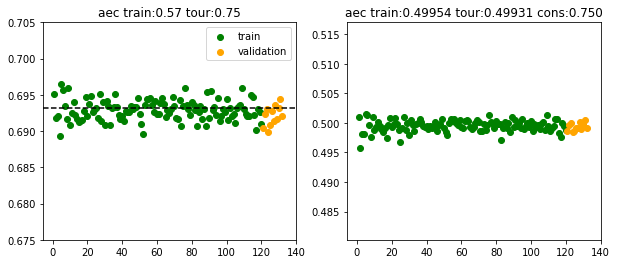

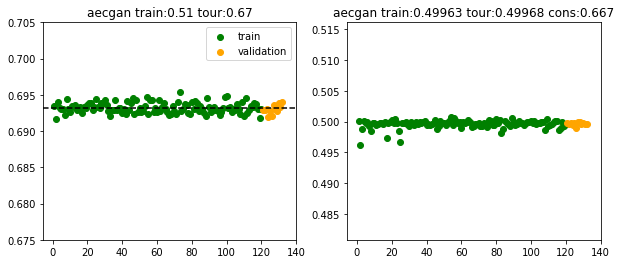

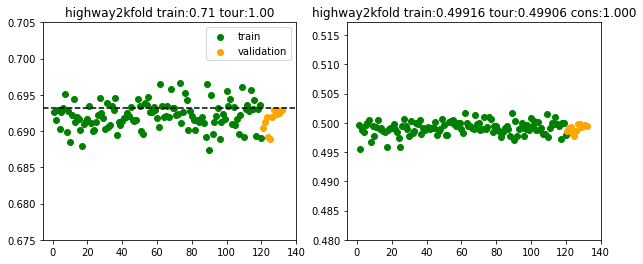

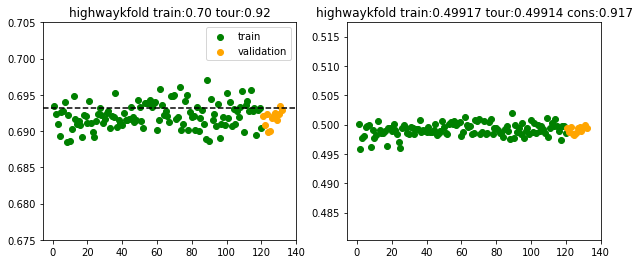

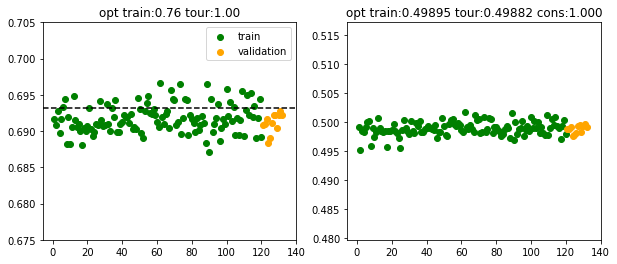

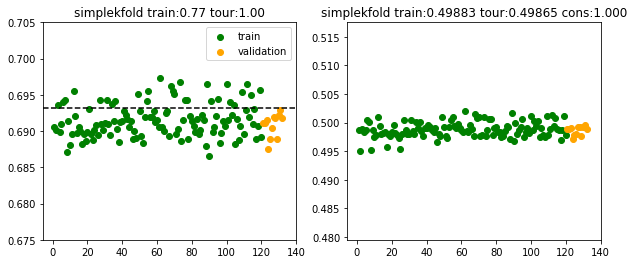

In [19]:
m_list = list(sorted(ll_list[0].keys()))

for n,mn in enumerate(m_list):
    tr_dn=np.sum(ll_list[0][mn].log_loss < -np.log(0.5))
    tr_nu=ll_list[0][mn].log_loss.shape[0]
    tr_cons=tr_dn/float(tr_nu)
    tr_std=ll_list[0][mn].stds.mean()
    print(mn)
    print('{:1.5f} {:1.4f} {} {}'.format(tr_std,tr_cons,tr_dn,tr_nu))
    tor_dn=np.sum(ll_list[1][mn].log_loss < -np.log(0.5))
    tor_nu=ll_list[1][mn].log_loss.shape[0]
    tor_std=ll_list[1][mn].stds.mean()
    tor_cons=tor_dn/float(tor_nu)
    print('{:1.5f} {:1.4f} {} {}'.format(tor_std,tor_cons,tor_dn,tor_nu))
    print('--')
    plt.figure(n,figsize=(10,4))
    plt.subplot(121)
    plt.title('{} train:{:1.2f} tour:{:1.2f}'.format(mn,tr_cons,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
    plt.ylim(0.675,0.705)
    plt.legend()
    plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
    plt.subplot(122)
    plt.title('{} train:{:1.5f} tour:{:1.5f} cons:{:1.3f}'.format(mn,tr_std,tor_std,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].stds,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].stds,label='validation',color='orange')


In [31]:
m_list = ['disentangle_kfold']
for n,mn in enumerate(m_list):
    tr_dn=np.sum(ll_list[0][mn].log_loss < -np.log(0.5))
    tr_nu=ll_list[0][mn].log_loss.shape[0]
    tr_cons=tr_dn/float(tr_nu)
    tr_std=ll_list[0][mn].stds.mean()
    print(mn)
    print('{:1.5f} {:1.4f} {} {}'.format(tr_std,tr_cons,tr_dn,tr_nu))
    tor_dn=np.sum(ll_list[1][mn].log_loss < -np.log(0.5))
    tor_nu=ll_list[1][mn].log_loss.shape[0]
    tor_std=ll_list[1][mn].stds.mean()
    tor_cons=tor_dn/float(tor_nu)
    print('{:1.5f} {:1.4f} {} {}'.format(tor_std,tor_cons,tor_dn,tor_nu))
    print('--')
    plt.figure(n,figsize=(10,4))
    plt.subplot(121)
    plt.title('{} train:{:1.2f} tour:{:1.2f}'.format(mn,tr_cons,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
    plt.ylim(0.690,0.695)
    plt.legend()
    plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
    plt.subplot(122)
    plt.title('{} train:{:1.5f} tour:{:1.5f} cons:{:1.3f}'.format(mn,tr_std,tor_std,tor_cons))
    plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].stds,label='train',color='green')
    plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].stds,label='validation',color='orange')


KeyError: 'disentangle_kfold'

In [ ]:
aec=models.aec.AecModel()
aec.load()
adv=models.aec_gan.AecAdvModel()
adv.load()
adx=models.aec_gan_xg.AecGanXgModel()
adx.load()

In [ ]:
for x in [X_train,X_val,X_test]:
    aecdX = aec.decoder.predict(x)
    advdX = adv.decoder.predict(x)
    adxdX = adx.aa_inst.decoder.predict(x)
    print('---------')
    print('aec',metrics.mean_squared_error(aecdX,x))
    print('adv',metrics.mean_squared_error(advdX,x))
    print('adx',metrics.mean_squared_error(adxdX,x))

In [ ]:
mn = 'aecganxg'
plt.figure(0)
plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
plt.figure(1)
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

#X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
#X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

# Score on the training set was:0.6049871246781169
# exported_pipeline = make_pipeline(
#     FastICA(tol=0.35000000000000003),
#     StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=14, n_estimators=100)),
#     ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=17, min_samples_split=13, n_estimators=100)
# )
args = [
    FastICA(tol=0.35000000000000003),
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=7, n_estimators=100)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=, min_samples_split=6, n_estimators=80),

]
exported_pipeline = make_pipeline(
    *args,
    memory=memory
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)


import pickle
with open('mymodel','wb') as f:
    pickle.dump(model,f)

In [ ]:
for p in ['trainpath','testpath']:
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    results = exported_pipeline.predict_proba(X__)
    val_eras = [x for x in np.unique(eras__) if x not in ['eraX']]
    ll = {}
    name = 'tpot'
    ll[name]=[]
    for era in val_eras:
        inds = np.array(np.where(eras__==era)).squeeze()
        l = opt.log_loss_func([1.],[results[inds]],y__[inds])
        ll[name].append({'eras':to_int(era),'log_loss':l})
    ll[name] = pd.DataFrame(ll[name])
    ll_list.append(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))


In [ ]:
opt_weights = opt.opt_weights(y_pred_list,y_test[val_inds])

In [ ]:
opt_pred = opt.opt_pred(y_pred_list,opt_weights)
print(len(y_pred_list),opt_weights.shape,opt_pred.shape)
print('final logloss',name,opt.log_loss_func([1.0],[opt_pred],y_test[val_inds]))

In [ ]:
print(['{:.8f}'.format(x) for x in opt_weights])
print(np.sum(opt_weights))